# 第6回講義 演習

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchtext.legacy
from torchtext.legacy import data
from torchtext.legacy import datasets
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42

In [ ]:
# torch.log(0)によるnanを防ぐための関数
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

## 目次

課題1. Recurrent Neural Network (RNN) によるIMDbのsentiment analysis
1. データセットの読み込み
2. 各層クラスの実装
4. 学習

課題2. torch.nn.RNN, torch.nn.Embeddingを用いたネットワークの記述

課題3. Long short-term memory (LSTM)

【補足】Gradient Clipping（長系列への対処法）

## 課題1. Recurrent Neural Network (RNN) によるIMDbのsentiment analysis

IMDb (Internet Movie Database) と呼ばれるデータセットには、映画のレビュー文とその評価がpositiveかnegativeかが記録されています。

<div style="text-align: center;">【データセットのイメージ】</div>

| レビュー | 評価 |
|:--------:|:-------------:|
|Where's Michael Caine when you need him? I've ...|negative|
|To experience Head you really need to understa...|positive|

そこで各レビュー文を入力として、その評価をRNNを用いて予測してみましょう。

### 1. データセットの読み込み

自然言語処理において、データとなる文をそのままネットワークに入力することは出来ないので、適切な前処理をする必要があります。

前処理の手順（英文の場合）は大まかに、
- 単語ごとに区切る
- 各単語にIDを割り振る

という手順で行われ、この手順を経ることで、元々の文は整数列に変換され、ネットワークに入力することが可能となります。

また、本演習では各単語にIDを割り振る処理に torchtext [[link]](https://pytorch.org/text/) と呼ばれるライブラリを用いています。詳しく知りたい方は、公式ドキュメントを参照してください。

In [ ]:
import string
import re

# 以下の記号はスペースに置き換えます（カンマ、ピリオドを除く）。
# punctuationとは日本語で句点という意味です
print("区切り文字：", string.punctuation)
# !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

# 前処理


def preprocessing_text(text):
    # 改行コードを消去
    text = re.sub('<br />', '', text)

    # カンマ、ピリオド以外の記号をスペースに置換
    for p in string.punctuation:
        if (p == ".") or (p == ","):
            continue
        else:
            text = text.replace(p, " ")

    # ピリオドなどの前後にはスペースを入れておく
    text = text.replace(".", " . ")
    text = text.replace(",", " , ")
    return text

# 分かち書き（今回はデータが英語で、簡易的にスペースで区切る）


def tokenizer_punctuation(text):
    return text.strip().split()


# 前処理と分かち書きをまとめた関数を定義
def tokenizer_with_preprocessing(text):
    text = preprocessing_text(text)
    ret = tokenizer_punctuation(text)
    return ret


# 動作を確認します
print(tokenizer_with_preprocessing('I like cats.'))

In [ ]:
# 文章とラベルの両方に用意します
max_length = 256
TEXT = data.Field(sequential=True, tokenize=tokenizer_with_preprocessing,
                  use_vocab=True, lower=True, include_lengths=True,
                  batch_first=True, fix_length=max_length,
                  init_token="<cls>", eos_token="<eos>")
LABEL = data.Field(sequential=False, use_vocab=True)

# 引数の意味は次の通り
# max_length：最大系列長
# init_token：全部の文章で、文頭に入れておく単語
# eos_token：全部の文章で、文末に入れておく単語


train_data, _ = datasets.IMDB.splits(text_field=TEXT,
                                             label_field=LABEL)
train_data, valid_data = train_data.split(0.8)



In [ ]:
word_num = 10000

TEXT.build_vocab(train_data, max_size=word_num)
LABEL.build_vocab(train_data)

In [ ]:
batch_size = 100

train_dl = torchtext.legacy.data.Iterator(train_data, batch_size=batch_size,
                                   train=True, sort=True)

valid_dl = torchtext.legacy.data.Iterator(valid_data, batch_size=batch_size,
                                   train=False, sort=False)

### 2. 各層クラスの実装

#### 2.1. Embedding層

Embedding層では、単語を離散的なidから連続的な数百次元のベクトルに変換(埋め込み、embed)します。

下のEmbeddingクラスにおいて、入力$\boldsymbol{x}$は各行に文の単語のid列が入った行列で、重み$\boldsymbol{V}$は各行がそれぞれの単語idのベクトルに対応した行列です。

つまりそれぞれの行列のサイズは

- $\boldsymbol{x}$: (ミニバッチサイズ) x (ミニバッチ内の文の最大系列長)
- $\boldsymbol{V}$: (辞書の単語数) x (単語のベクトルの次元数)

です。

この$\boldsymbol{V}$から、入力$\boldsymbol{x}$のそれぞれの単語idに対して対応する単語ベクトルを取り出すことで、各単語をベクトルに変換します。

この処理によって出力されるテンソルの次元数は、(ミニバッチサイズ) x (ミニバッチ内の文の最大系列長) x (単語のベクトルの次元数)となります。

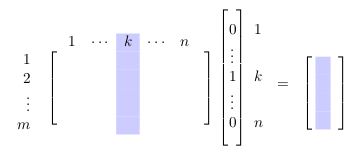

$$m:\text{emb_dim}, \ n : \text{vocab_size}$$


In [ ]:
class Embedding(nn.Module):
    def __init__(self, emb_dim, vocab_size):
        super().__init__()
        self.embedding_matrix = nn.Parameter(torch.rand((vocab_size, emb_dim),
                                                        dtype=torch.float))

    def forward(self, x):
        return F.embedding(x, self.embedding_matrix)

# Emb = Embedding(100, word_num + 4) として '<unk>', '<pad>', '<cls>', '<eos>'の数を忘れないようにする

#### 2.2. RNN

RNNクラスでは、Embedding層で各単語がベクトルに変換されたものを入力として処理を行います。ここで入力$\boldsymbol{x}$は

- $\boldsymbol{x}$: (ミニバッチサイズ) x (ミニバッチ内の文の最大系列長) x (単語のベクトルの次元数)

となっています。

ここでは nn.Module を用いてRNNクラスを定義します。

In [ ]:
class RNN(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        glorot = 6/(in_dim + hid_dim*2)
        self.W = nn.Parameter(torch.tensor(rng.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

    def function(self, h, x):
        return torch.tanh(torch.matmul(torch.cat([h, x], dim=1), self.W) + self.b)

    def forward(self, x, len_seq_max=0, init_state=None):
        x = x.transpose(0, 1)  # 系列のバッチ処理のため、次元の順番を「系列、バッチ」の順に入れ替える
        state = init_state
        
        if init_state is None:  # 初期値を設定しない場合は0で初期化する
            state = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)

        size = list(state.unsqueeze(0).size())
        size[0] = 0
        output = torch.empty(size, dtype=torch.float).to(x.device)  # 一旦空テンソルを定義して順次出力を追加する

        if len_seq_max == 0:
            len_seq_max = x.size(0)
        for i in range(len_seq_max):
            state = self.function(state, x[i])
            output = torch.cat([output, state.unsqueeze(0)])  # 出力系列の追加
        return output

In [ ]:
class SequenceTaggingNet(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = Embedding(emb_dim, word_num)
        self.rnn = RNN(emb_dim, hid_dim)
        self.linear = nn.Linear(hid_dim, 1)

    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)
        h = self.rnn(h, len_seq_max, init_state)
        if len_seq is not None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.linear(h)
        return y

### 3. 学習

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 5
device = 'cuda'

net = SequenceTaggingNet(word_num + 4, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    net.train()
    n_train = 0
    acc_train = 0
    for mini_batch in train_dl:

        net.zero_grad()  # 勾配の初期化

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
      
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        loss.backward()  # 誤差の逆伝播
        
        optimizer.step()  # パラメータの更新

        losses_train.append(loss.tolist())

        n_train += t.size()[0]
    
    # Valid
    t_valid = []
    y_pred = []
    net.eval()
    for mini_batch in valid_dl:

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
        
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        pred = y.round().squeeze()  # 0.5以上の値を持つ要素を正ラベルと予測する

        t_valid.extend(t.tolist())
        y_pred.extend(pred.tolist())

        losses_valid.append(loss.tolist())
          
    print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
        epoch,
        np.mean(losses_train),
        np.mean(losses_valid),
        f1_score(t_valid, y_pred, average='macro')
    ))

## 課題2. torch.nn.RNN, torch.nn.Embedding を用いたネットワークの記述

`torch.nn.Conv2d`を用いてCNN層を容易に実装することができたように、`torch.nn.RNN`を用いることで容易にRNN層を実装することができます。

torch.nn.RNNは、系列データxと初期状態h_0を引数として受け取り、出力系列yと最終状態hを出力します。
`y, h = self.RNN(x, h_0)`

また、少し厄介なことにnn.RNNの入力の系列データは、デフォルトで次元が [系列、ミニバッチ、各要素のベクトル] の順番となっています。しかしながら、データローダーが与えるデータは [ミニバッチ、系列、各要素]の順番となっており、この順番の方が直感的であると考えられます。これを解決するため、torch.nn.RNNは引数 batch_firstを受け取ることができ、これをTrueにすることで入力系列を [ミニバッチ、系列、各要素] の順番で受け取ることができます。

batch_first=Trueとすると出力の順番も入れ替わるので、transposeを用いて [系列、ミニバッチ、各要素のベクトル] としてからlen_seqを元に最終出力を取り出します。

さらに、torch.nn.RNNは引数 num_layers を持ち、RNNを何層重ねるかを指定します。多層に重ねることもできますが、ここでは課題2の実装と揃えるため一層とします。

また、torch.nn.Embeddingを用いることでEmbedding層も容易に実装することができます。

In [ ]:
class SequenceTaggingNet2(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.emb = nn.Embedding(word_num, emb_dim)  # nn.Embeddingの使用
        self.rnn = nn.RNN(emb_dim, hid_dim, 1, batch_first=True)  # nn.RNNの使用
        self.linear = nn.Linear(hid_dim, 1)
        
    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.emb(x)
        if len_seq_max > 0:
            h, _ = self.rnn(h[:, 0:len_seq_max, :], init_state)
        else:
            h, _ = self.rnn(h, init_state)
        h = h.transpose(0, 1)
        if len_seq is None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.linear(h)
        
        return y

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet2(word_num + 4, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    net.train()
    n_train = 0
    acc_train = 0
    for mini_batch in train_dl:

        net.zero_grad()  # 勾配の初期化

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
      
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        loss.backward()  # 誤差の逆伝播
        
        optimizer.step()  # パラメータの更新
        
        pred = y.round().squeeze()  # 0.5以上の値を持つ要素を正ラベルと予測する

        acc_train += (pred == t).float().sum().item()

        losses_train.append(loss.tolist())

        n_train += t.size()[0]
    
    # Valid
    t_valid = []
    y_pred = []
    net.eval()
    for mini_batch in valid_dl:

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
        
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        pred = y.round().squeeze()  # 0.5以上の値を持つ要素を正ラベルと予測する

        t_valid.extend(t.tolist())
        y_pred.extend(pred.tolist())

        losses_valid.append(loss.tolist())
        
    print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
        epoch,
        np.mean(losses_train),
        np.mean(losses_valid),
        f1_score(t_valid, y_pred, average='macro')
    ))

## 課題3. Long short-term memory (LSTM)

実装する式は次のようになります。($\odot$は要素ごとの積)

- 入力ゲート: $\hspace{20mm}\boldsymbol{i}_t = \mathrm{\sigma} \left(\boldsymbol{W}_i \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_i\right)$
- 忘却ゲート: $\hspace{20mm}\boldsymbol{f}_t = \mathrm{\sigma} \left(\boldsymbol{W}_f \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_f\right)$  
- 出力ゲート: $\hspace{20mm}\boldsymbol{o}_t = \mathrm{\sigma} \left(\boldsymbol{W}_o \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_o\right)$  
- セル:　　　 $\hspace{20mm}\boldsymbol{c}_t = \boldsymbol{f}_t \odot \boldsymbol{c}_{t-1} + \boldsymbol{i}_t \odot \tanh \left(\boldsymbol{W}_c \left[\begin{array}{c} \boldsymbol{x}_t \\ \boldsymbol{h}_{t-1} \end{array}\right] + \boldsymbol{b}_c\right)$
- 隠れ状態: 　$\hspace{20mm}\boldsymbol{h}_t = \boldsymbol{o}_t \odot \tanh \left(\boldsymbol{c}_t \right)$

単純なRNNでは各ステップの関数の戻り値は隠れ状態のみ ($\boldsymbol{h}_t$) でしたが、LSTMではセル状態と隠れ状態の2つ ($\boldsymbol{c}_t, \boldsymbol{h}_t$) となるので注意してください。

In [ ]:
class LSTM(nn.Module):
    def __init__(self, in_dim, hid_dim):
        super().__init__()
        self.hid_dim = hid_dim
        glorot = 6/(in_dim + hid_dim*2)

        self.W_i = nn.Parameter(torch.tensor(rng.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_i = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_f = nn.Parameter(torch.tensor(rng.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_f = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_o = nn.Parameter(torch.tensor(rng.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_o = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

        self.W_c = nn.Parameter(torch.tensor(rng.uniform(
                        low=-np.sqrt(glorot),
                        high=np.sqrt(glorot),
                        size=(in_dim + hid_dim, hid_dim)
                    ).astype('float32')))
        self.b_c = nn.Parameter(torch.tensor(np.zeros([hid_dim]).astype('float32')))

    def function(self, state_c, state_h, x):
        i = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_i) + self.b_i)
        f = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_f) + self.b_f)
        o = torch.sigmoid(torch.matmul(torch.cat([state_h, x], dim=1), self.W_o) + self.b_o)
        c = f*state_c + i*torch.tanh(torch.matmul(torch.cat([state_h, x], dim=1), self.W_c) + self.b_c)
        h = o*torch.tanh(c)
        return c, h

    def forward(self, x, len_seq_max=0, init_state_c=None, init_state_h=None):
        x = x.transpose(0, 1)  # 系列のバッチ処理のため、次元の順番を「系列、バッチ」の順に入れ替える
        state_c = init_state_c
        state_h = init_state_h
        if init_state_c is None:  # 初期値を設定しない場合は0で初期化する
            state_c = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)
        if init_state_h is None:  # 初期値を設定しない場合は0で初期化する
            state_h = torch.zeros((x[0].size()[0], self.hid_dim)).to(x.device)

        size = list(state_h.unsqueeze(0).size())
        size[0] = 0
        output = torch.empty(size, dtype=torch.float).to(x.device)  # 一旦空テンソルを定義して順次出力を追加する
        
        if len_seq_max == 0:
            len_seq_max = x.size(0)
        for i in range(len_seq_max):
            state_c, state_h = self.function(state_c, state_h, x[i])
            output = torch.cat([output, state_h.unsqueeze(0)])  # 出力系列の追加
        return output

In [ ]:
class SequenceTaggingNet3(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.Emb = Embedding(emb_dim, word_num)
        self.LSTM = LSTM(emb_dim, hid_dim)
        self.Linear = nn.Linear(hid_dim, 1)
    
    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.Emb(x)
        h = self.LSTM(h, len_seq_max, init_state)
        if len_seq is not None:
            # 系列が終わった時点での出力を取る必要があるので len_seq を元に集約する
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.Linear(h)
        return y

同じタスクを用いてRNNとLSTMの性能を比較する。

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 5
device = 'cuda'

net = SequenceTaggingNet3(word_num + 4, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    net.train()
    n_train = 0
    acc_train = 0
    for mini_batch in train_dl:

        net.zero_grad()  # 勾配の初期化

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
      
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        loss.backward()  # 誤差の逆伝播
        
        optimizer.step()  # パラメータの更新

        losses_train.append(loss.tolist())

        n_train += t.size()[0]

    # Valid
    t_valid = []
    y_pred = []
    net.eval()
    for mini_batch in valid_dl:

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
        
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        pred = y.round().squeeze()  # 0.5以上の値を持つ要素を正ラベルと予測する

        t_valid.extend(t.tolist())
        y_pred.extend(pred.tolist())

        losses_valid.append(loss.tolist())
        
    print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
        epoch,
        np.mean(losses_train),
        np.mean(losses_valid),
        f1_score(t_valid, y_pred, average='macro')
    ))

LSTMもRNNと同様に,nn.LSTM を用いて実装することができます。

In [ ]:
class SequenceTaggingNet4(nn.Module):
    def __init__(self, word_num, emb_dim, hid_dim):
        super().__init__()
        self.Emb = nn.Embedding(word_num, emb_dim)
        self.RNN = nn.LSTM(emb_dim, hid_dim, 1, batch_first=True)  # nn.LSTMの使用
        self.Linear = nn.Linear(hid_dim, 1)
    
    def forward(self, x, len_seq_max=0, len_seq=None, init_state=None):
        h = self.Emb(x)
        if len_seq_max > 0:
            h, _ = self.RNN(h[:, 0:len_seq_max, :], init_state)
        else:
            h, _ = self.RNN(h, init_state)
        h = h.transpose(0, 1)
        if len_seq is not None:
            h = h[len_seq - 1, list(range(len(x))), :]
        else:
            h = h[-1]
        y = self.Linear(h)
        
        return y

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet4(word_num + 4, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    net.train()
    n_train = 0
    acc_train = 0
    for mini_batch in train_dl:

        net.zero_grad()  # 勾配の初期化

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
 
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        loss.backward()  # 誤差の逆伝播
        
        optimizer.step()  # パラメータの更新

        losses_train.append(loss.tolist())

        n_train += t.size()[0]

    # Valid
    t_valid = []
    y_pred = []
    net.eval()
    for mini_batch in valid_dl:

        t = mini_batch.label.to(device)-1  # テンソルをGPUに移動
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
        
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        pred = y.round().squeeze()  # 0.5以上の値を持つ要素を正ラベルと予測する

        t_valid.extend(t.tolist())
        y_pred.extend(pred.tolist())

        losses_valid.append(loss.tolist())
        
    print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
        epoch,
        np.mean(losses_train),
        np.mean(losses_valid),
        f1_score(t_valid, y_pred, average='macro')
    ))

## 【補足】Gradient Clipping（長系列への対処法）

LSTMは長系列に対しても学習がうまく行きやすいモデルでしたが、一般のRNNにおける長系列の学習のTipsとして、**Gradient Clipping**に触れておきます。

RNNでは誤差逆伝播法が特に**Back Propagation Through Time (BPTT)**と呼ばれるものになり、各層のみならず各時点の勾配が乗算されます。

そのため、通常よりも勾配が過大（或いは過小）になりやすいという特徴をもっています。

こうした現象を**勾配爆発（消失）**と呼びますが、勾配爆発は学習を不安定化し収束を困難にします。

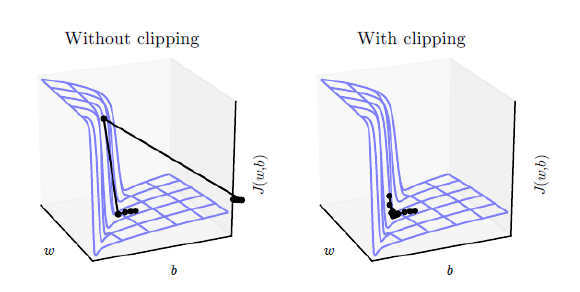
出典：Ian Goodfellow et. al, “Deep Learning”, MIT press, 2016 (http://www.deeplearningbook.org/)

そこで、勾配の大きさを意図的に制限して対処しようというのが、Gradient Clippingと呼ばれる手法です。

以下のように、`torch.nn.utils.clip_grad_norm_(parameters, max_norm)`を用いることで勾配をclippingすることができます。

この関数はparametersにmodelのパラメータ、max_normに勾配の絶対値の最大値を取ることで用いることができます。

In [ ]:
emb_dim = 100
hid_dim = 50
n_epochs = 10
device = 'cuda'

net = SequenceTaggingNet2(word_num + 4, emb_dim, hid_dim)
net.to(device)
optimizer = optim.Adam(net.parameters())

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    net.train()
    n_train = 0
    acc_train = 0
    for mini_batch in train_dl:

        net.zero_grad()

        t = mini_batch.label.to(device) - 1
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
      
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        loss.backward()

        # 勾配を絶対値1.0でクリッピングする
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        
        optimizer.step()

        losses_train.append(loss.tolist())

        n_train += t.size()[0]
    
    t_valid = []
    y_pred = []
    net.eval()
    for mini_batch in valid_dl:

        t = mini_batch.label.to(device) - 1
        x = mini_batch.text[0].to(device)
        len_seq = mini_batch.text[1].to(device)
        h = net(x, torch.max(len_seq), len_seq)
        y = torch.sigmoid(h).squeeze()
        
        loss = -torch.mean(t*torch_log(y) + (1 - t)*torch_log(1 - y))

        pred = y.round().squeeze()

        t_valid.extend(t.tolist())
        y_pred.extend(pred.tolist())

        losses_valid.append(loss.tolist())
        
    print('EPOCH: {}, Train Loss: {:.3f}, Valid Loss: {:.3f}, Validation F1: {:.3f}'.format(
        epoch,
        np.mean(losses_train),
        np.mean(losses_valid),
        f1_score(t_valid, y_pred, average='macro')
    ))